Данные

"dt" - year (2005.01.01-2023.12.01)

"region" - название федерального субъекта России (область, республика, край, округ, город федерального значения)

"wine" - продажи вина в литрах на душу населения помесячно

"beer" - продажи пива в литрах на душу населения помесячно

"vodka" - продажи водки в литрах на душу населения помесячно 

"champagne" - продажи шампанского в литрах на душу населения помесячно 

"brandy" - продажи брэнди в литрах на душу населения помесячно 

Анализ тестовых данных 

Подбор коэффициентов для модели SARIMA

In [20]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import os
import warnings

from sklearn.metrics import mean_squared_error
import warnings

from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

import pmdarima as pm
from pmdarima.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt


import itertools 
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('./russia_alcohol_monthly.csv')
df.tail()

,dt,region,wine,beer,vodka,champagne,brandy
18463,2023-08-01,Yaroslavl Oblast,0.8771,3.4031,0.8506,0.1554,0.1100
18464,2023-09-01,Yaroslavl Oblast,0.6433,4.2875,0.1856,0.1038,0.0479
18465,2023-10-01,Yaroslavl Oblast,0.4001,2.0523,0.1184,0.1284,0.0129
18466,2023-11-01,Yaroslavl Oblast,0.9678,3.7636,0.9174,0.1130,0.0567
18467,2023-12-01,Yaroslavl Oblast,1.0918,1.9754,0.9815,0.0929,0.0999


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18468 entries, 0 to 18467
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   dt         18468 non-null  object 
 1   region     18468 non-null  object 
 2   wine       18468 non-null  float64
 3   beer       18468 non-null  float64
 4   vodka      18468 non-null  float64
 5   champagne  18468 non-null  float64
 6   brandy     18468 non-null  float64
dtypes: float64(5), object(2)
memory usage: 1010.1+ KB


In [14]:
df.describe()

,wine,beer,vodka,champagne,brandy
count,18468.000000,18468.000000,18468.000000,18468.000000,18468.000000
mean,0.469795,4.310183,0.991867,0.109597,0.043682
std,0.296131,2.657150,0.563601,0.080427,0.038216
min,0.003400,0.017600,0.009600,0.001700,0.000000
25%,0.243900,2.311575,0.573650,0.053100,0.016600
50%,0.415800,3.847350,0.906700,0.092000,0.032900
75%,0.634025,5.856025,1.317175,0.143300,0.058000
max,2.363100,22.126300,5.565200,0.749700,0.277400


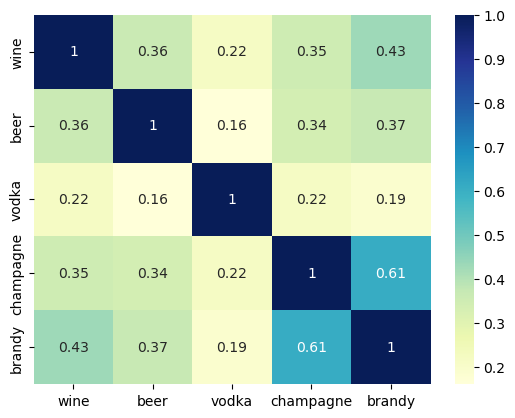

In [3]:
#Проверка корреляции напитков
d_df = df[['wine','beer','vodka', 'champagne', 'brandy']]
dataplot = sns.heatmap(d_df.corr(numeric_only=True), cmap="YlGnBu", annot=True)
plt.show()

In [21]:
#Прверка наличиня пустых строк
df.isna().sum()

dt           0
region       0
wine         0
beer         0
vodka        0
champagne    0
brandy       0
dtype: int64

In [22]:
df['dt'] = pd.to_datetime(df['dt'])


In [23]:
#Срез данных для тренировки
df_Moscow_t = df[df['region'] == 'Moscow']
df_Moscow_t 

,dt,region,wine,beer,vodka,champagne,brandy
8436,2005-01-01,Moscow,0.8230,3.1166,1.6852,0.4612,0.0824
8437,2005-02-01,Moscow,0.2910,2.7856,1.8722,0.1713,0.0291
8438,2005-03-01,Moscow,0.4332,2.1426,1.8865,0.4880,0.0847
8439,2005-04-01,Moscow,0.7274,1.6078,1.0326,0.0844,0.0803
8440,2005-05-01,Moscow,0.5896,3.4449,2.3502,0.3320,0.0811
...,...,...,...,...,...,...,...
8659,2023-08-01,Moscow,0.4031,4.2487,0.5960,0.2555,0.1224
8660,2023-09-01,Moscow,0.1505,5.6994,1.4949,0.3118,0.0670
8661,2023-10-01,Moscow,0.8359,3.9064,0.3863,0.2941,0.0996
8662,2023-11-01,Moscow,0.3343,8.5722,0.5693,0.1078,0.1204


In [24]:
#Добавим столбец с суммой по всем типам
df_Moscow_t["total_alcohol"] = (
      df_Moscow_t["wine"]
    + df_Moscow_t["brandy"]
    + df_Moscow_t["vodka"]
    + df_Moscow_t["beer"]
    + df_Moscow_t["champagne"]
)

In [25]:
df_Moscow_t

,dt,region,wine,beer,vodka,champagne,brandy,total_alcohol
8436,2005-01-01,Moscow,0.8230,3.1166,1.6852,0.4612,0.0824,6.1684
8437,2005-02-01,Moscow,0.2910,2.7856,1.8722,0.1713,0.0291,5.1492
8438,2005-03-01,Moscow,0.4332,2.1426,1.8865,0.4880,0.0847,5.0350
8439,2005-04-01,Moscow,0.7274,1.6078,1.0326,0.0844,0.0803,3.5325
8440,2005-05-01,Moscow,0.5896,3.4449,2.3502,0.3320,0.0811,6.7978
...,...,...,...,...,...,...,...,...
8659,2023-08-01,Moscow,0.4031,4.2487,0.5960,0.2555,0.1224,5.6257
8660,2023-09-01,Moscow,0.1505,5.6994,1.4949,0.3118,0.0670,7.7236
8661,2023-10-01,Moscow,0.8359,3.9064,0.3863,0.2941,0.0996,5.5223
8662,2023-11-01,Moscow,0.3343,8.5722,0.5693,0.1078,0.1204,9.7040


In [26]:
df_Moscow_t['day'] = df_Moscow_t.dt.dt.day
df_Moscow_t['month'] = df_Moscow_t.dt.dt.month
df_Moscow_t['year'] = df_Moscow_t.dt.dt.year
df_Moscow_t

,dt,region,wine,beer,vodka,champagne,brandy,total_alcohol,day,month,year
8436,2005-01-01,Moscow,0.8230,3.1166,1.6852,0.4612,0.0824,6.1684,1,1,2005
8437,2005-02-01,Moscow,0.2910,2.7856,1.8722,0.1713,0.0291,5.1492,1,2,2005
8438,2005-03-01,Moscow,0.4332,2.1426,1.8865,0.4880,0.0847,5.0350,1,3,2005
8439,2005-04-01,Moscow,0.7274,1.6078,1.0326,0.0844,0.0803,3.5325,1,4,2005
8440,2005-05-01,Moscow,0.5896,3.4449,2.3502,0.3320,0.0811,6.7978,1,5,2005
...,...,...,...,...,...,...,...,...,...,...,...
8659,2023-08-01,Moscow,0.4031,4.2487,0.5960,0.2555,0.1224,5.6257,1,8,2023
8660,2023-09-01,Moscow,0.1505,5.6994,1.4949,0.3118,0.0670,7.7236,1,9,2023
8661,2023-10-01,Moscow,0.8359,3.9064,0.3863,0.2941,0.0996,5.5223,1,10,2023
8662,2023-11-01,Moscow,0.3343,8.5722,0.5693,0.1078,0.1204,9.7040,1,11,2023


In [27]:
df_Moscow_t = df_Moscow_t.set_index('dt')

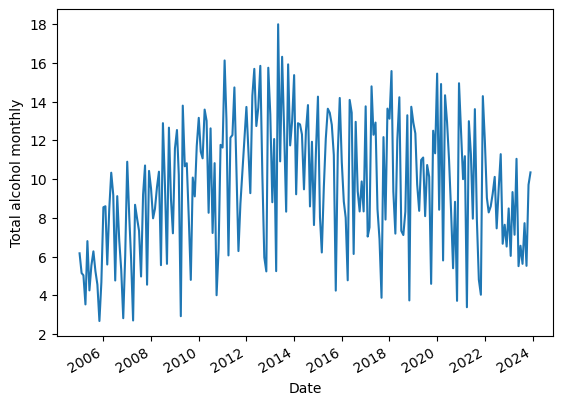

<Figure size 1500x700 with 0 Axes>

In [28]:
fig, ax = plt.subplots()
plt.figure(figsize=(15,7))
ax.plot(df_Moscow_t.total_alcohol)
ax.set_xlabel('Date')
ax.set_ylabel('Total alcohol monthly')
fig.autofmt_xdate()
plt.tight_layout()

**Анализ данных**

Проверка наличия трендов, сезонности

In [29]:
advanced_decomposition = STL(df_Moscow_t.total_alcohol, period=2).fit()

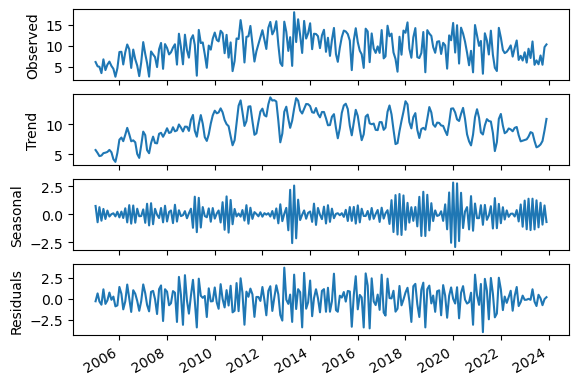

<Figure size 1500x800 with 0 Axes>

In [30]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True)
plt.figure(figsize=(15,8))
ax1.plot(advanced_decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(advanced_decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(advanced_decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(advanced_decomposition.resid)
ax4.set_ylabel('Residuals')

fig.autofmt_xdate()
plt.tight_layout()


**Тест Дики — Фуллера**

Анализ временных рядов для проверки на стационарность

In [31]:

print('Results of Dickey Fuller Test:')
dftest = adfuller(df_Moscow_t['total_alcohol'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                  -2.415379
p-value                          0.137443
#Lags Used                      13.000000
Number of Observations Used    214.000000
Critical Value (1%)             -3.461282
Critical Value (5%)             -2.875143
Critical Value (10%)            -2.574020
dtype: float64


Видим, что данные нестационарные

**Графики Функции автокорреляции** 

**ACF, PACF**

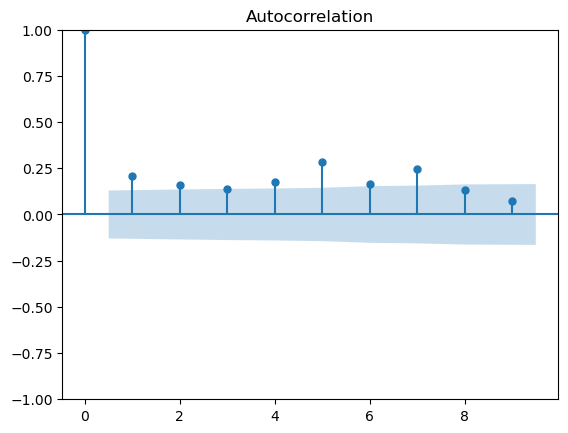

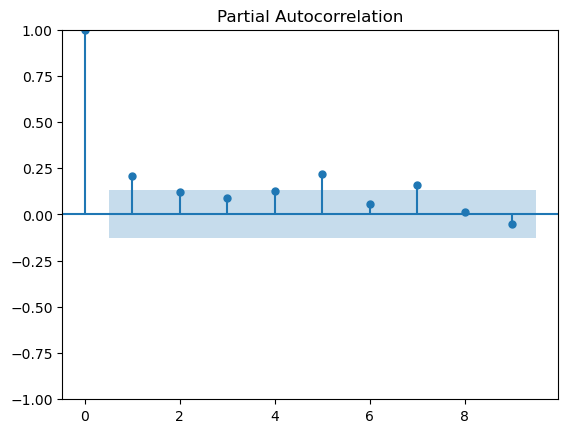

In [14]:
plot_acf(df_Moscow_t['total_alcohol'], lags=9)
plot_pacf(df_Moscow_t['total_alcohol'], lags=9)
plt.show()

**Determine rolling statistics**

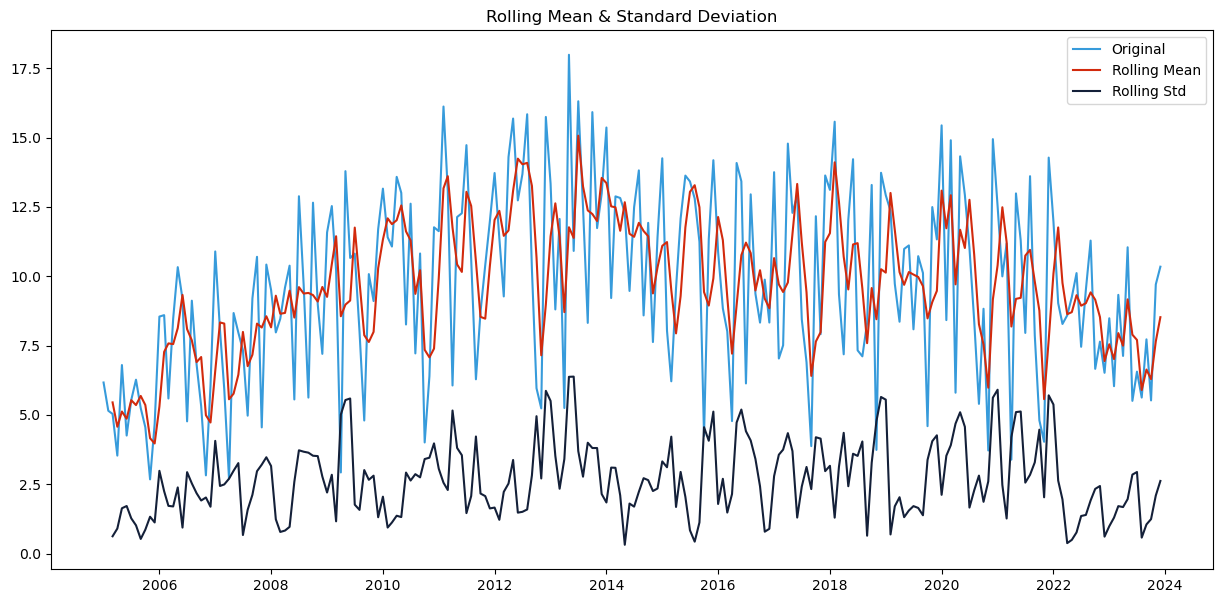

In [15]:
df_Moscow_t["rolling_avg"] = df_Moscow_t["total_alcohol"].rolling(window=3).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
df_Moscow_t["rolling_std"] = df_Moscow_t["total_alcohol"].rolling(window=3).std()

#Plot rolling statistics
plt.figure(figsize=(15,7))
plt.plot(df_Moscow_t["total_alcohol"], color='#379BDB', label='Original')
plt.plot(df_Moscow_t["rolling_avg"], color='#D22A0D', label='Rolling Mean')
plt.plot(df_Moscow_t["rolling_std"], color='#142039', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

**Подбираем коэффициенты для модели SARIMA**

In [13]:
df_Moscow_t = df_Moscow_t['total_alcohol']

In [14]:
def search_optimal_sarima(df_Moscow_t, seasonal_cycle):
    order_vals = diff_vals = ma_vals = range(0, 2)
    pdq_combinations = list(itertools.product(order_vals, diff_vals, ma_vals))    
    seasonal_combinations = [(combo[0], combo[1], combo[2], seasonal_cycle) for combo in pdq_combinations]
    
    smallest_aic = float("inf")
    optimal_order_param = optimal_seasonal_param = None
    
    for order_param in pdq_combinations:
        for seasonal_param in seasonal_combinations:
            try:
                sarima_model = SARIMAX(df_Moscow_t,
                                       order=order_param,
                                       seasonal_order=seasonal_param,
                                       enforce_stationarity=False,
                                       enforce_invertibility=False)
                model_results = sarima_model.fit(disp=False)                               
                if model_results.aic < smallest_aic:
                    smallest_aic = model_results.aic
                    optimal_order_param = order_param
                    optimal_seasonal_param = seasonal_param
            except Exception as e:
               
                print(f"Error fitting model with params {order_param} and seasonal param {seasonal_param}: {e}")
                continue

    # Print the results
    print('SARIMA{}x{} - AIC:{}'.format(optimal_order_param, optimal_seasonal_param, smallest_aic))


seasonal_cycle_length = 12
search_optimal_sarima(df_Moscow_t, seasonal_cycle_length)

SARIMA(1, 1, 1)x(0, 1, 1, 12) - AIC:1010.4076285843953


**Рассчитанные параметры**
SARIMA(1, 1, 1)x(0, 1, 1, 12) - AIC:1010.4076285843953

In [16]:
df_Moscow_t

dt
2005-01-01     6.1684
2005-02-01     5.1492
2005-03-01     5.0350
2005-04-01     3.5325
2005-05-01     6.7978
               ...   
2023-08-01     5.6257
2023-09-01     7.7236
2023-10-01     5.5223
2023-11-01     9.7040
2023-12-01    10.3434
Name: total_alcohol, Length: 228, dtype: float64

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.46685D+00    |proj g|=  1.19026D-01

At iterate    5    f=  2.33906D+00    |proj g|=  2.16211D-02

At iterate   10    f=  2.33631D+00    |proj g|=  6.32299D-03


 This problem is unconstrained.



At iterate   15    f=  2.33601D+00    |proj g|=  4.88932D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     23      1     0     0   9.569D-06   2.336D+00
  F =   2.3360070469644851     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Mean Absolute Percentage Error (MAPE): 41.93%


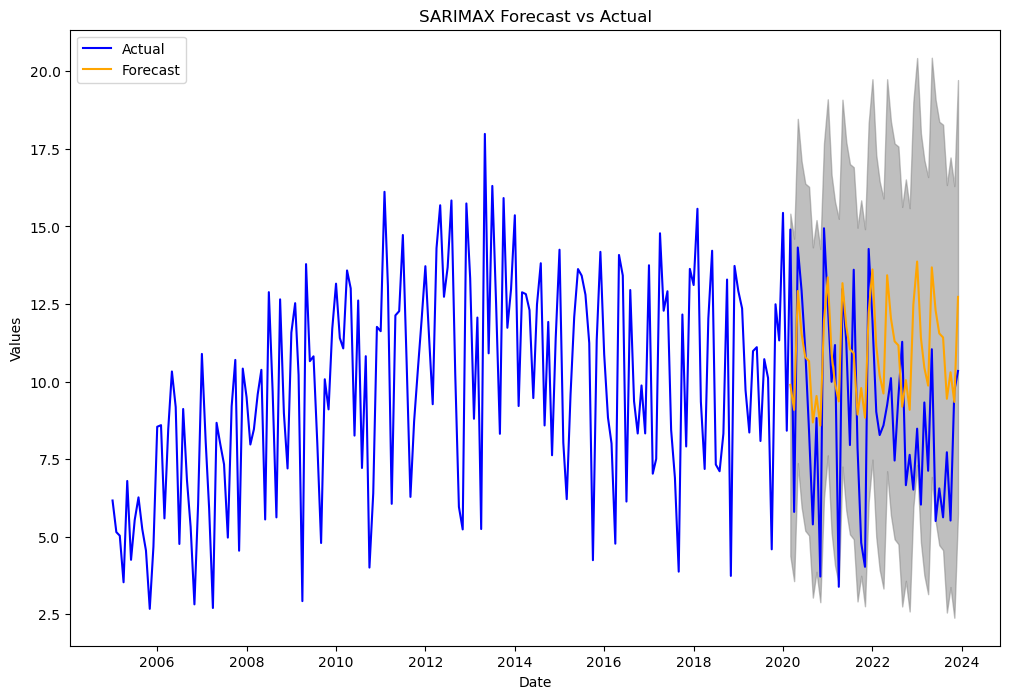

In [19]:
train_size = int(len(df_Moscow_t) * 0.8)
train_data, test_data = df_Moscow_t[:train_size], df_Moscow_t[train_size:]

model = SARIMAX(df_Moscow_t[:train_size], order=(1, 1, 1), seasonal_order=(0, 1, 1, 12))
results = model.fit()

predictions = results.get_forecast(steps=len(test_data))
mean_prediction = predictions.predicted_mean
ci_95 = predictions.conf_int(alpha=0.05)

mape = np.mean(np.abs((test_data - mean_prediction) / test_data)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

plot_df = pd.DataFrame({
    'Actual': test_data,
    'Forecast': mean_prediction,
    'Lower CI': ci_95.iloc[:, 0],
    'Upper CI': ci_95.iloc[:, 1]
})


plt.figure(figsize=(12, 8))
plt.plot(df_Moscow_t, label='Actual', color='blue')
plt.plot(plot_df['Forecast'], label='Forecast', color='orange')
plt.fill_between(plot_df.index, plot_df['Lower CI'], plot_df['Upper CI'], color='gray', alpha=0.5)
plt.title('SARIMAX Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()

# Calculate Mean Absolute Percentage Error (MAPE)
#mape = np.mean(np.abs((test_data - mean_prediction) / test_data)) * 100

#print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")